In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Input,Conv2D,MaxPool2D,Activation,Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping,History

#Understanding and visualizing Data

In [2]:
data_path = '/content/drive/MyDrive/my projects/Brain Tumor Detection/brain_tumor_dataset'

In [3]:
classes_folders = os.listdir(data_path)
classes_folders

['no', 'yes']

In [4]:
sample_image = plt.imread('/content/drive/MyDrive/my projects/Brain Tumor Detection/brain_tumor_dataset/yes/Y1.jpg')

In [5]:
sample_image.shape,sample_image.dtype,np.min(sample_image),np.max(sample_image)

((218, 180, 3), dtype('uint8'), 0, 255)

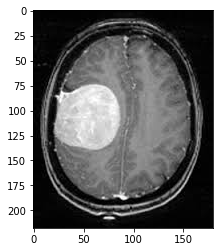

In [6]:
plt.imshow(sample_image)

reshaping image 

In [7]:
sample_image = load_img('/content/drive/MyDrive/my projects/Brain Tumor Detection/brain_tumor_dataset/yes/Y1.jpg',target_size=(256,256))

In [8]:
sample_image = img_to_array(sample_image,dtype=np.float32)

In [9]:
sample_image.shape,sample_image.dtype,np.min(sample_image),np.max(sample_image)

((256, 256, 3), dtype('float32'), 0.0, 255.0)

In [10]:
sample_image = sample_image / 255.0

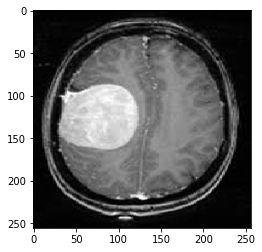

In [11]:
plt.imshow(sample_image)

In [12]:
sample_image.dtype

dtype('float32')

#preparing data 

In [13]:
def preprocessing_image(image_path):
  image = load_img(image_path,target_size=(256,256))
  image = img_to_array(image,dtype=np.float32)
  image = image / 255.0
  return image

In [14]:
def prepare_data(data_path):
  class_folder_names = os.listdir(data_path)
  images = []
  classes = []

  for class_folder_name in class_folder_names:

    images_name = os.listdir(os.path.join(data_path,class_folder_name))
    images_path = [os.path.join(data_path,class_folder_name,image_name) for image_name in images_name]
    
    images = images + list(map(preprocessing_image,images_path))
    
    if class_folder_name == 'yes':
      classes = classes + [1] * len(images_path)
    else:
      classes = classes + [0] * len(images_path)
  
  images = np.stack(images)
  classes = np.stack(classes)
  classes = classes.reshape(images.shape[0],1)
  
  images,classes = shuffle(images,classes)
  return images,classes

In [15]:
X,y = prepare_data('/content/drive/MyDrive/my projects/Brain Tumor Detection/brain_tumor_dataset')

In [16]:
y = y.astype(np.float32)

In [17]:
X.shape,y.shape

((253, 256, 256, 3), (253, 1))

Text(0.5, 1.0, 'class = [1.]')

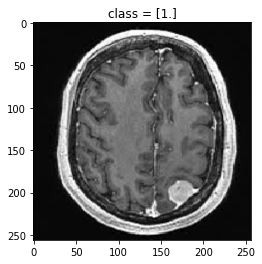

In [18]:
plt.imshow(X[0])
plt.title(f'class = {y[0]}')

In [19]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1, random_state=42)

In [20]:
X_test.shape,np.squeeze(sum(y_test))

((26, 256, 256, 3), array(15., dtype=float32))

#Data augmentation 

In [21]:
from imgaug import augmenters as iaa

In [22]:
rotation_seq  = iaa.Sequential([
    iaa.Affine(rotate=(-30, 30))])

rotation_flip_seq = iaa.Sequential([
    iaa.Affine(rotate=(-30, 30)), # rotate the image
    iaa.Fliplr(1.0) #do horizontal flip
])

In [23]:
sequences = [rotation_seq,rotation_flip_seq]

In [24]:
rotation_images = []
rotation_flip_images = []

aug_images  = [rotation_images,rotation_flip_images]

In [25]:
for count,current_images in enumerate(aug_images):
  
  duplicate_images = X_train.copy()

  m = duplicate_images.shape[0]

  for i in range(m):

    current_seq = sequences[count]

    image_aug = current_seq.augment_image(duplicate_images[i])

    current_images.append(image_aug)

In [26]:
X_train = np.concatenate((X_train,np.stack(aug_images[0]),np.stack(aug_images[1])))

In [27]:
y_train = np.concatenate((y_train,y_train,y_train))

In [28]:
X_train.shape,y_train.shape

((681, 256, 256, 3), (681, 1))

In [29]:
X_train,y_train = shuffle(X_train,y_train)

Text(0.5, 1.0, 'class = [1.]')

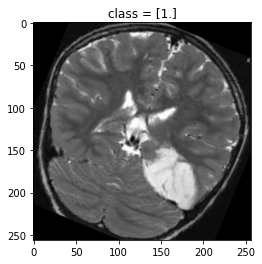

In [30]:
plt.imshow(X_train[110])
plt.title(f'class = {y_train[110]}')

#Build and training Model

In [31]:
from tensorflow.keras.applications.xception import Xception

In [32]:
base_model = Xception(include_top=False,input_shape=(256,256,3))

83697664/83683744 [==============================] - 1s 0us/step


In [33]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [34]:
#Transfer learning
base_model.trainable = False

In [35]:
def make_brain_tumor_model(input_shape):
  inputs = Input(shape=input_shape)

  x = base_model(inputs)

  x = Conv2D(2048*2,kernel_size=2,strides=(2,2))(x)

  x = MaxPool2D()(x)

  x = Activation('relu')(x)

  x = GlobalAveragePooling2D()(x)
  
  x = Dense(1024,activation='relu')(x)

  outputs = Dense(1,activation='sigmoid')(x)

  model = Model(inputs,outputs)

  return model

In [36]:
brain_tumor_model = make_brain_tumor_model((256,256,3))

In [37]:
brain_tumor_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 4096)        33558528  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 4096)        0         
_________________________________________________________________
activation (Activation)      (None, 2, 2, 4096)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              419532

training model

In [38]:
#defining callback list
save_mode_path = '/content/drive/MyDrive/my projects/Brain Tumor Detection/saved_model'
best_weight_saver = ModelCheckpoint(os.path.join(save_mode_path,'model.h5'),save_best_only=True)
earlystopper = EarlyStopping(patience=5,restore_best_weights=True)
reduce_learing_rate = ReduceLROnPlateau(patience=3)
callback_list = [best_weight_saver,earlystopper,reduce_learing_rate]

In [40]:
brain_tumor_model.compile(optimizer=Adam(learning_rate=0.001),loss=binary_crossentropy,metrics=["accuracy"])

In [41]:
history = brain_tumor_model.fit(X_train,y_train,validation_split=0.1,epochs=6,callbacks=callback_list)

Epoch 1/6
20/20 [==============================] - 47s 651ms/step - loss: 3.2668 - accuracy: 0.6977 - val_loss: 0.3103 - val_accuracy: 0.9130


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/6
20/20 [==============================] - 10s 503ms/step - loss: 0.3671 - accuracy: 0.8464 - val_loss: 0.3210 - val_accuracy: 0.8696
Epoch 3/6
20/20 [==============================] - 10s 503ms/step - loss: 0.2051 - accuracy: 0.9167 - val_loss: 0.1403 - val_accuracy: 0.9565
Epoch 4/6
20/20 [==============================] - 10s 502ms/step - loss: 0.1027 - accuracy: 0.9706 - val_loss: 0.0595 - val_accuracy: 0.9710
Epoch 5/6
20/20 [==============================] - 10s 498ms/step - loss: 0.0514 - accuracy: 0.9837 - val_loss: 0.0923 - val_accuracy: 0.9565
Epoch 6/6
20/20 [==============================] - 10s 498ms/step - loss: 0.0214 - accuracy: 0.9951 - val_loss: 0.0567 - val_accuracy: 0.9710


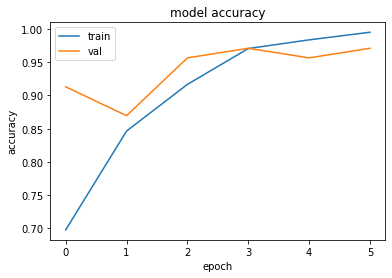

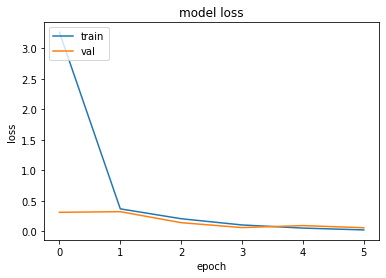

In [43]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

fine tuning

In [46]:
base_model.trainable=True

In [47]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  132


In [49]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [52]:
brain_tumor_model.compile(optimizer=Adam(learning_rate=0.0001),
                          loss=binary_crossentropy,
                          metrics=["accuracy"])

In [53]:
history_fine = brain_tumor_model.fit(X_train,y_train,validation_split=0.1,epochs=4,callbacks=callback_list)

Epoch 1/4
20/20 [==============================] - 21s 857ms/step - loss: 0.2023 - accuracy: 0.9232 - val_loss: 0.2664 - val_accuracy: 0.9565
Epoch 2/4
20/20 [==============================] - 16s 789ms/step - loss: 0.0329 - accuracy: 0.9886 - val_loss: 0.1277 - val_accuracy: 0.9855
Epoch 3/4
20/20 [==============================] - 16s 787ms/step - loss: 0.0112 - accuracy: 0.9951 - val_loss: 0.0804 - val_accuracy: 0.9710
Epoch 4/4
20/20 [==============================] - 16s 786ms/step - loss: 0.0671 - accuracy: 0.9804 - val_loss: 0.0766 - val_accuracy: 0.9565


In [55]:
total_epochs = 10
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

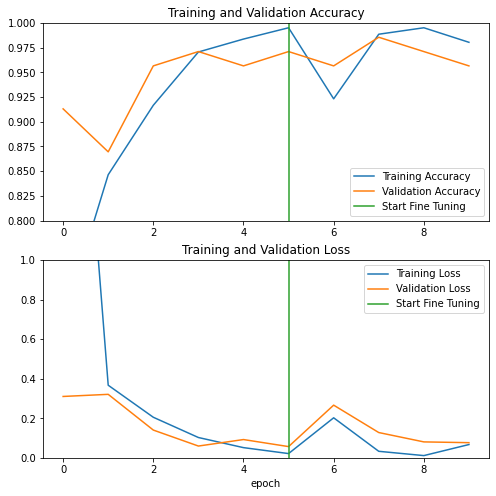

In [57]:
initial_epochs = 6
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

evaluate model on test set

In [58]:
brain_tumor_model.evaluate(X_train,y_train)

22/22 [==============================] - 9s 417ms/step - loss: 0.0277 - accuracy: 0.9868


[0.027659457176923752, 0.9867841601371765]

In [59]:
brain_tumor_model.evaluate(X_test,y_test)

1/1 [==============================] - 0s 403ms/step - loss: 0.3933 - accuracy: 0.9231


[0.3933395743370056, 0.9230769276618958]

#Saliency Map

In [60]:
import cv2
import tensorflow as tf

In [61]:
def show_saliency_map(X_test,y_test,class_idx):

  idx = 0
  count=0
  for i in range(y_test.shape[0]):
    if(y_test[i] == class_idx):
      idx = i

      break 
  
  saliency_input = X_test[idx]
  expected_output = y_test[idx]

  saliency_input = np.expand_dims(saliency_input,axis=0)
  expected_output = np.expand_dims(expected_output,axis=0)

  saliency_input = tf.convert_to_tensor(saliency_input)
  expected_output = tf.convert_to_tensor(expected_output)

  
  with tf.GradientTape() as tape:

    tape.watch(saliency_input)

    # generate the predictions
    predictions = brain_tumor_model(saliency_input)

    print(predictions)

    # get the loss
    loss = binary_crossentropy(
        expected_output, predictions
    )
  
  gradients = tape.gradient(loss, saliency_input)

  # reduce the RGB image to grayscale
  grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

  # normalize the pixel values to be in the range [0, 255].
  # the max value in the grayscale tensor will be pushed to 255.
  # the min value will be pushed to 0.
  normalized_tensor = tf.cast(255* (grayscale_tensor - tf.reduce_min(grayscale_tensor))/ (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),tf.uint8,)

  # remove the channel dimension to make the tensor a 2d tensor
  normalized_tensor = tf.squeeze(normalized_tensor)

  gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
  gradient_color = gradient_color / 255.0
  saliency_input = tf.squeeze(saliency_input,axis=0)
  super_imposed = saliency_input + gradient_color

  plt.figure(figsize=(10,8))
  plt.imshow(super_imposed)
  plt.title(f"predicted class = {np.squeeze(predictions)} actual class = {class_idx}")

tf.Tensor([[7.421368e-05]], shape=(1, 1), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor([[1.]], shape=(1, 1), dtype=float32)


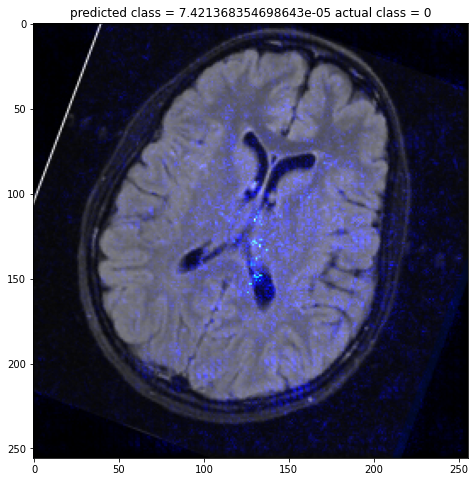

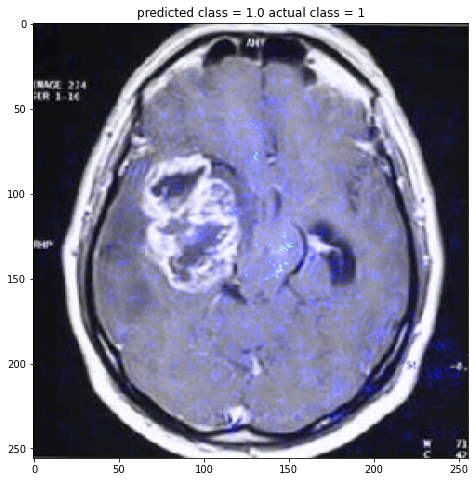

In [62]:
for i in range(2):
  show_saliency_map(X_train,y_train,i)